Loading data...
Initializing tokenizer...
Initializing model...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training on cuda...
Epoch 1/5
  Average training loss: 0.5994
  Average validation loss: 0.5528
                  precision    recall  f1-score   support

         history       0.00      0.00      0.00        30
            food       0.00      0.00      0.00        26
       adventure       0.00      0.00      0.00        24
         culture       0.00      0.00      0.00        34
          nature       0.00      0.00      0.00        33
      relaxation       0.00      0.00      0.00        18
        shopping       0.00      0.00      0.00        33
       nightlife       0.00      0.00      0.00        31
          family       0.00      0.00      0.00        25
local_experience       0.00      0.00      0.00        19
          luxury       0.00      0.00      0.00        13
budget_conscious       0.00      0.00      0.00        15
   accessibility       0.00      0.00      0.00        17
     early_riser       0.00      0.00      0.00        15
       night_owl       0.00      

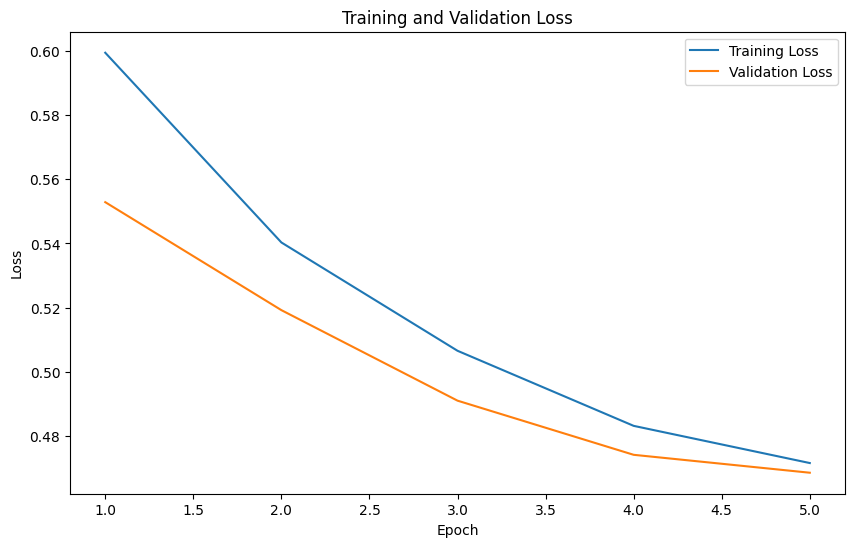

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# Define preference categories
PREFERENCE_CATEGORIES = [
    # Core interests
    "history", "food", "adventure", "culture", "nature",
    "relaxation", "shopping", "nightlife", "family",

    # Additional nuanced preferences
    "local_experience", "luxury", "budget_conscious", "accessibility",
    "early_riser", "night_owl", "off_beaten_path", "instagram_worthy",
    "needs_breaks", "sustainable", "vegetarian", "group_activities"
]

class PreferenceDataset(Dataset):
    """PyTorch dataset for preference classification"""

    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]

        # Tokenize text
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Remove batch dimension
        item = {k: v.squeeze(0) for k, v in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)

        return item

def train_model(data_path="data/preference_dataset.csv",
                model_output_dir="models/preference_encoder",
                batch_size=16,
                epochs=5,
                learning_rate=2e-5,
                max_length=128):
    """Train a DistilBERT model for preference classification"""

    # Load data
    print("Loading data...")
    df = pd.read_csv(data_path)

    # Extract labels from columns that start with 'label_'
    label_columns = [col for col in df.columns if col.startswith('label_')]
    labels = df[label_columns].values

    # Extract descriptions
    texts = df['description'].tolist()

    # Split data
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        texts, labels, test_size=0.1, random_state=42
    )

    # Initialize tokenizer
    print("Initializing tokenizer...")
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

    # Create datasets
    train_dataset = PreferenceDataset(train_texts, train_labels, tokenizer, max_length)
    val_dataset = PreferenceDataset(val_texts, val_labels, tokenizer, max_length)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Initialize model
    print("Initializing model...")
    model = DistilBertForSequenceClassification.from_pretrained(
        'distilbert-base-uncased',
        num_labels=len(PREFERENCE_CATEGORIES),
        problem_type="multi_label_classification"
    )

    # Prepare optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Training loop
    print(f"Training on {device}...")

    # Keep track of loss values for plotting
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Training
        model.train()
        train_loss = 0
        for batch in train_loader:
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}

            # Forward pass
            outputs = model(**batch)
            loss = outputs.loss

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"  Average training loss: {avg_train_loss:.4f}")

        # Validation
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in val_loader:
                # Move batch to device
                batch = {k: v.to(device) for k, v in batch.items()}
                labels = batch.pop('labels')

                # Forward pass
                outputs = model(**batch)
                logits = outputs.logits

                # Compute loss
                loss_fn = torch.nn.BCEWithLogitsLoss()
                loss = loss_fn(logits, labels)
                val_loss += loss.item()

                # Convert logits to predictions (0 or 1)
                preds = torch.sigmoid(logits)
                preds = (preds > 0.5).float()

                all_preds.append(preds.cpu().numpy())
                all_labels.append(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"  Average validation loss: {avg_val_loss:.4f}")

        # Compute classification metrics
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)

        report = classification_report(
            all_labels, all_preds,
            target_names=[col.replace('label_', '') for col in label_columns],
            zero_division=0
        )
        print(report)

    # Create the output directory if it doesn't exist
    os.makedirs(model_output_dir, exist_ok=True)

    # Save model and tokenizer
    print(f"Saving model to {model_output_dir}...")
    model.save_pretrained(model_output_dir)
    tokenizer.save_pretrained(model_output_dir)

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs+1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig(os.path.join(model_output_dir, 'training_loss.png'))

    return model, tokenizer

if __name__ == "__main__":
    # Train the model
    data_path = "/kaggle/input/preference-classification-v2/preference_dataset.csv"
    model_output_dir = "/kaggle/working"

    train_model(
        data_path=data_path,
        model_output_dir=model_output_dir,
        batch_size=16,
        epochs=5
    )

    print("Training complete!")

Loading data...
Class distribution:
  history: 263/838 (31.4%)
  food: 288/838 (34.4%)
  adventure: 185/838 (22.1%)
  culture: 308/838 (36.8%)
  nature: 295/838 (35.2%)
  relaxation: 215/838 (25.7%)
  shopping: 292/838 (34.8%)
  nightlife: 332/838 (39.6%)
  family: 294/838 (35.1%)
  local_experience: 183/838 (21.8%)
  luxury: 170/838 (20.3%)
  budget_conscious: 159/838 (19.0%)
  accessibility: 174/838 (20.8%)
  early_riser: 148/838 (17.7%)
  night_owl: 162/838 (19.3%)
  off_beaten_path: 138/838 (16.5%)
  instagram_worthy: 184/838 (22.0%)
  needs_breaks: 129/838 (15.4%)
  sustainable: 196/838 (23.4%)
  vegetarian: 211/838 (25.2%)
  group_activities: 195/838 (23.3%)
Performing data augmentation for underrepresented classes...
  Added 2 examples for luxury
  Added 13 examples for budget_conscious
  Added 24 examples for early_riser
  Added 10 examples for night_owl
  Added 34 examples for off_beaten_path
  Added 43 examples for needs_breaks
Total examples after augmentation: 964
Initializ

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Initializing model: bert-base-uncased...


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using Focal Loss for training
Training on cuda...
Epoch 1/15
  Batch 50/103, Loss: 0.1487
  Batch 100/103, Loss: 0.1430
  Average training loss: 0.1611
Optimal thresholds:
  history: 0.441
  food: 0.451
  adventure: 0.351
  culture: 0.416
  nature: 0.453
  relaxation: 0.405
  shopping: 0.435
  nightlife: 0.450
  family: 0.424
  local_experience: 0.381
  luxury: 0.359
  budget_conscious: 0.332
  accessibility: 0.358
  early_riser: 0.402
  night_owl: 0.379
  off_beaten_path: 0.381
  instagram_worthy: 0.405
  needs_breaks: 0.349
  sustainable: 0.393
  vegetarian: 0.401
  group_activities: 0.343
  Average validation loss: 0.1417
Average Precision Scores:
  history: 0.617
  food: 0.543
  adventure: 0.296
  culture: 0.399
  nature: 0.509
  relaxation: 0.296
  shopping: 0.342
  nightlife: 0.600
  family: 0.717
  local_experience: 0.486
  luxury: 0.275
  budget_conscious: 0.270
  accessibility: 0.244
  early_riser: 0.489
  night_owl: 0.243
  off_beaten_path: 0.331
  instagram_worthy: 0.710
  n

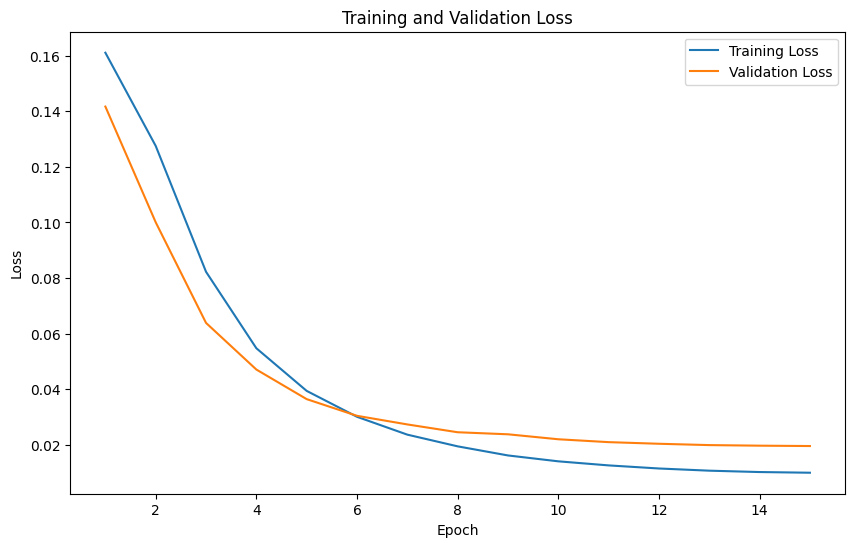

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from collections import Counter

# Define preference categories
PREFERENCE_CATEGORIES = [
    # Core interests
    "history", "food", "adventure", "culture", "nature",
    "relaxation", "shopping", "nightlife", "family",

    # Additional nuanced preferences
    "local_experience", "luxury", "budget_conscious", "accessibility",
    "early_riser", "night_owl", "off_beaten_path", "instagram_worthy",
    "needs_breaks", "sustainable", "vegetarian", "group_activities"
]

class FocalLoss(torch.nn.Module):
    """Focal Loss for addressing class imbalance problems"""
    def __init__(self, alpha=1, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce = torch.nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, inputs, targets):
        BCE_loss = self.bce(inputs, targets)
        pt = torch.exp(-BCE_loss)  # prevents nans when probability 0
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return F_loss.mean()

class PreferenceDataset(Dataset):
    """PyTorch dataset for preference classification"""

    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]

        # Tokenize text
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Remove batch dimension
        item = {k: v.squeeze(0) for k, v in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)

        return item

def find_optimal_thresholds(val_probs, val_labels):
    """Find optimal threshold for each class based on F1 score"""
    optimal_thresholds = []

    for i in range(val_labels.shape[1]):
        # For each class, find the threshold that gives the best F1 score
        precisions, recalls, thresholds = precision_recall_curve(val_labels[:, i], val_probs[:, i])

        # Calculate F1 for each threshold
        f1_scores = 2 * precisions * recalls / (precisions + recalls + 1e-8)

        # Find threshold with best F1
        if len(thresholds) > 0:
            best_idx = np.argmax(f1_scores[:-1])  # exclude the last point which doesn't have a threshold
            optimal_thresholds.append(thresholds[best_idx])
        else:
            # If no thresholds (e.g., all predictions are the same), use default
            optimal_thresholds.append(0.3)

    return optimal_thresholds

def train_model(data_path="data/preference_dataset.csv",
                model_output_dir="models/preference_encoder",
                batch_size=8,
                epochs=15,
                learning_rate=3e-5,
                max_length=128,
                focal_loss=True,
                model_name="bert-base-uncased"):  # Changed to BERT instead of DistilBERT
    """Train a transformer model for preference classification"""

    # Load data
    print("Loading data...")
    df = pd.read_csv(data_path)

    # Extract labels from columns that start with 'label_'
    label_columns = [col for col in df.columns if col.startswith('label_')]
    labels = df[label_columns].values

    # Print class distribution
    print("Class distribution:")
    for i, col in enumerate(label_columns):
        pos_count = np.sum(labels[:, i])
        print(f"  {col.replace('label_', '')}: {pos_count}/{len(labels)} ({pos_count/len(labels)*100:.1f}%)")

    # Data augmentation for underrepresented classes
    # This creates additional training examples for classes with fewer instances
    print("Performing data augmentation for underrepresented classes...")

    # Calculate average number of examples per class
    avg_examples = np.mean([np.sum(labels[:, i]) for i in range(labels.shape[1])])

    # Get original data
    texts = df['description'].tolist()
    augmented_texts = texts.copy()
    augmented_labels = labels.copy()

    # Simple data augmentation by duplicating examples from underrepresented classes
    for i, col in enumerate(label_columns):
        col_name = col.replace('label_', '')
        pos_count = np.sum(labels[:, i])

        # If class has fewer examples than average, duplicate some examples
        if pos_count < avg_examples * 0.8:  # Target classes less than 80% of average
            examples_needed = int(avg_examples * 0.8) - pos_count
            pos_indices = np.where(labels[:, i] == 1)[0]

            if len(pos_indices) > 0:  # Make sure we have at least some positive examples
                # Randomly select indices to duplicate (with replacement if needed)
                dup_indices = np.random.choice(pos_indices, size=examples_needed, replace=True)

                # Add duplicated examples
                for idx in dup_indices:
                    augmented_texts.append(texts[idx])
                    augmented_labels = np.vstack([augmented_labels, labels[idx]])

                print(f"  Added {examples_needed} examples for {col_name}")

    # Update texts and labels with augmented data
    texts = augmented_texts
    labels = augmented_labels

    # Extract descriptions
    print(f"Total examples after augmentation: {len(texts)}")

    # Split data with stratification based on total label count per example
    label_counts = np.sum(labels, axis=1)
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        texts, labels, test_size=0.15, random_state=42,
        stratify=pd.qcut(label_counts, q=min(5, len(np.unique(label_counts))),
                        labels=False, duplicates='drop')
    )

    # Initialize tokenizer based on model name
    print(f"Initializing tokenizer for {model_name}...")
    if "bert-base" in model_name:
        tokenizer = BertTokenizer.from_pretrained(model_name)
    else:
        tokenizer = DistilBertTokenizer.from_pretrained(model_name)

    # Create datasets
    train_dataset = PreferenceDataset(train_texts, train_labels, tokenizer, max_length)
    val_dataset = PreferenceDataset(val_texts, val_labels, tokenizer, max_length)

    # Create data loaders with higher batch size for faster training
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size*2)

    # Initialize model based on name
    print(f"Initializing model: {model_name}...")
    if "bert-base" in model_name:
        model = BertForSequenceClassification.from_pretrained(
            model_name,
            num_labels=len(label_columns),
            problem_type="multi_label_classification"
        )
    else:
        model = DistilBertForSequenceClassification.from_pretrained(
            model_name,
            num_labels=len(label_columns),
            problem_type="multi_label_classification"
        )

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Prepare optimizer with weight decay and learning rate
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
         'weight_decay': 0.01},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
         'weight_decay': 0.0}
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)

    # Learning rate scheduler with warmup
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * total_steps),  # 10% of total steps for warmup
        num_training_steps=total_steps
    )

    # Initialize loss function
    if focal_loss:
        criterion = FocalLoss(gamma=2.0)  # Focal loss helps with class imbalance
        print("Using Focal Loss for training")
    else:
        criterion = torch.nn.BCEWithLogitsLoss()
        print("Using BCE Loss for training")

    # Training loop
    print(f"Training on {device}...")

    # Keep track of metrics for plotting
    train_losses = []
    val_losses = []
    best_f1 = 0
    best_model = None
    best_thresholds = None
    patience = 3  # Early stopping patience
    no_improve_epochs = 0

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Training
        model.train()
        train_loss = 0
        for batch_idx, batch in enumerate(train_loader):
            # Move batch to device
            batch = {k: v.to(device) for k, v in batch.items()}
            labels = batch.pop('labels')

            # Forward pass
            outputs = model(**batch)
            logits = outputs.logits

            # Compute loss
            loss = criterion(logits, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
            optimizer.step()
            scheduler.step()

            train_loss += loss.item()

            # Print progress every 50 batches
            if (batch_idx + 1) % 50 == 0:
                print(f"  Batch {batch_idx + 1}/{len(train_loader)}, Loss: {loss.item():.4f}")

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"  Average training loss: {avg_train_loss:.4f}")

        # Validation
        model.eval()
        val_loss = 0
        all_preds = []
        all_labels = []
        all_probs = []

        with torch.no_grad():
            for batch in val_loader:
                # Move batch to device
                batch = {k: v.to(device) for k, v in batch.items()}
                labels = batch.pop('labels')

                # Forward pass
                outputs = model(**batch)
                logits = outputs.logits

                # Compute loss with class weights
                loss = criterion(logits, labels)
                val_loss += loss.item()

                # Store probabilities and true labels
                probs = torch.sigmoid(logits)
                all_probs.append(probs.cpu().numpy())
                all_labels.append(labels.cpu().numpy())

        # Concatenate all batches
        all_probs = np.concatenate(all_probs)
        all_labels = np.concatenate(all_labels)

        # Find optimal thresholds based on validation data
        optimal_thresholds = find_optimal_thresholds(all_probs, all_labels)

        # Apply optimal thresholds to get predictions
        all_preds = np.zeros_like(all_probs)
        for i, threshold in enumerate(optimal_thresholds):
            all_preds[:, i] = (all_probs[:, i] > threshold).astype(float)

        # Log thresholds
        print("Optimal thresholds:")
        for i, (col, threshold) in enumerate(zip([col.replace('label_', '') for col in label_columns], optimal_thresholds)):
            print(f"  {col}: {threshold:.3f}")

        # Calculate average validation loss
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        print(f"  Average validation loss: {avg_val_loss:.4f}")

        # Calculate average precision score (APS) for each class
        aps_scores = []
        for i in range(all_labels.shape[1]):
            aps = average_precision_score(all_labels[:, i], all_probs[:, i])
            aps_scores.append(aps)

        print("Average Precision Scores:")
        for i, (col, aps) in enumerate(zip([col.replace('label_', '') for col in label_columns], aps_scores)):
            print(f"  {col}: {aps:.3f}")

        # Print prediction distributions
        print("Prediction distribution:")
        for i, col in enumerate([col.replace('label_', '') for col in label_columns]):
            pred_count = np.sum(all_preds[:, i])
            print(f"  {col}: {pred_count}/{len(all_preds)} ({pred_count/len(all_preds)*100:.1f}%)")

        # Calculate F1 score
        from sklearn.metrics import f1_score
        f1_micro = f1_score(all_labels, all_preds, average='micro')
        f1_macro = f1_score(all_labels, all_preds, average='macro')
        f1_weighted = f1_score(all_labels, all_preds, average='weighted')

        print(f"  F1 scores - Micro: {f1_micro:.4f}, Macro: {f1_macro:.4f}, Weighted: {f1_weighted:.4f}")

        # Save best model based on F1-macro score
        if f1_macro > best_f1:
            best_f1 = f1_macro
            best_model = model.state_dict().copy()
            best_thresholds = optimal_thresholds
            no_improve_epochs = 0
            print(f"  New best model saved with F1-macro: {best_f1:.4f}")
        else:
            no_improve_epochs += 1
            print(f"  No improvement for {no_improve_epochs} epochs")

        # Early stopping check
        if no_improve_epochs >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

        # Print classification report
        report = classification_report(
            all_labels, all_preds,
            target_names=[col.replace('label_', '') for col in label_columns],
            zero_division=0
        )
        print(report)

    # Create the output directory if it doesn't exist
    os.makedirs(model_output_dir, exist_ok=True)

    # Load best model for saving
    if best_model is not None:
        model.load_state_dict(best_model)

    # Save model and tokenizer
    print(f"Saving model to {model_output_dir}...")
    model.save_pretrained(model_output_dir)
    tokenizer.save_pretrained(model_output_dir)

    # Save optimal thresholds
    if best_thresholds is not None:
        thresholds_dict = {
            label_columns[i].replace('label_', ''): float(best_thresholds[i])
            for i in range(len(label_columns))
        }
        np.save(os.path.join(model_output_dir, 'optimal_thresholds.npy'), thresholds_dict)

        # Also save as text file for easy reference
        with open(os.path.join(model_output_dir, 'optimal_thresholds.txt'), 'w') as f:
            for label, threshold in thresholds_dict.items():
                f.write(f"{label}: {threshold}\n")

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig(os.path.join(model_output_dir, 'training_loss.png'))

    return model, tokenizer, best_thresholds

if __name__ == "__main__":
    # Train the model
    data_path = "/kaggle/input/preference-classification-v2/preference_dataset.csv"
    model_output_dir = "/kaggle/working"

    train_model(
        data_path=data_path,
        model_output_dir=model_output_dir,
        batch_size=8,
        epochs=15,
        learning_rate=3e-5,
        focal_loss=True,
        model_name="bert-base-uncased"  # Use BERT instead of DistilBERT for better performance
    )

    print("Training complete!")